Food for thought https://towardsdatascience.com/predicting-housing-prices-using-advanced-regression-techniques-8dba539f9abe

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import Normalizer
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [1]:
df.columns


NameError: name 'df' is not defined

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
plt.style.use('ggplot')
df.hist(figsize = (20,20));

## TO CLEAN
Need to define catagories: view, waterfront, condition, floors...? 

yr_renovated needs to be dealt with as well. 

I have to check for empty cells as well as checking for incorrect data types.

______________________________________
I want to see how many houses show up twice in our data.

In [ ]:
sum(df.id.value_counts() <= 1), sum(df.id.value_counts() > 1)

There looks like there are 176 properties that were sold more than one and 21224 properites that only appeare on this list once. I am not sure that I can do anything with this.

In [ ]:
df.isna().sum()

In [ ]:
df.info()

Lets change sqft_basement data type


In [3]:
df.sqft_basement = df.sqft_basement.astype('float')

ValueError: could not convert string to float: '?'

It looks like there may be some placeholder in the data.

In [ ]:
sum(df.sqft_basement == "?")

There are 454 '?' placeholders in the .sqft_basement . I will need to take care of them.

In [4]:
mask = df.sqft_basement == '?' #This sets ou condtional situation.
column_name = 'sqft_basement' #Not sure why I did this here if I could just do it in the next step.
df.loc[mask, column_name] = 0

In [ ]:
df.loc[df.sqft_basement == '?', 'sqft_basement'] = 0 #Works the same way above.

In [5]:
df.sqft_basement = df.sqft_basement.astype('float64')

In [ ]:
to_plot1 = df.loc[df.waterfront.isna()]
to_plot = to_plot1.loc[to_plot1.long >= -122.7]
to_plot.shape

In [ ]:
agua = [8888000055,623039026, 573000685,1822039138, 6398000191,8550001515,5215200010, 6102400166, 7632400400]
to_plot.waterfront = np.where(to_plot.id.isin(agua), 1, 0)
df.fillna(to_plot, inplace=True)
df.waterfront.isna().sum() #seeing the number go down makes me feel better

In [ ]:
import os
import folium
from folium.plugins import MarkerCluster

In [ ]:
m = folium.Map(
    location = [to_plot.lat.mean(), to_plot.long.mean()],
)

marker_cluster = MarkerCluster(
    name = 'house_prices',
    overlay = True,
    control = False,
    icon_create_function = None
)

size = len(to_plot)
lats = list(to_plot.lat)
lons = list(to_plot.long)
ids = list(to_plot.id)

for k in range(size):
    location = lats[k], lons[k]
    marker = folium.Marker(location=location)
    popup = 'id:{}<br>lon:{}<br>lat:{}'.format(ids[k],location[1], location[0])
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)


marker_cluster.add_to(m)

folium.LayerControl().add_to(m)
m

In [ ]:
m = folium.Map(location=[47.54832,-122.229983], zoom_start=3)

m.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=df,
    columns=['price'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
)


folium.LayerControl().add_to(m)

m

In [ ]:
#temp.apply(lambda row:folium.Marker(location=[row["lat"], row["long"]]).add_to(m),axis=1);

In [ ]:
#df.to_pickle("./cleaned_data")

In [8]:
df = pd.read_pickle('cleaned_data')
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3749
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
delta_lot           0
delta_living        0
dtype: int64

reno - built = time until first renovation. Then we can safely take away a subset of data leaving us with some remaining NAN values.

In [ ]:
plt.style.use('ggplot')

BUT FIRST, Lets check the how random the missing data is using a nifty library missingno: https://github.com/ResidentMario/missingno *Learn how to do hyperlinks in markup

In [ ]:
import missingno as msno

In [ ]:
df = df.replace("nan", np.nan) #makes all the nan values into the pandas friendly version. 
msno.matrix(df.sample(300))

So this shows us a sample of our data set and where the data is missing. It looks fairly random.

In [ ]:
msno.dendrogram(df)

Viewing the dendrogram, we can see that the missing waterfront and yr_renovated do not correspond within their own missing data.

In [ ]:
msno.geoplot(df, x='long', y='lat')

In [ ]:
msno.geoplot(df, x='long', y='lat', by='zipcode')

So we are grouping this data into relative regions of lat and long, which allows up to check the geographic distribution of the missing data. The number of values left blank range by almost 10% and the distances look random enough (there is no disproption in the western rurals areas). **Look at an side by side comparison to the map**

## To FINALLY clean the yr_renovated data, lets use some statistical imputation

In [ ]:
renovate = df.loc[df.yr_renovated.isna()] #makes a new DataFrame with a containing the subset of all missing yr_renovated

renovate['delta_lot'] = np.where(renovate.sqft_lot != renovate.sqft_lot15, 1, 0) #making two new columns that will let us know if there were any changes in the sqft of house or lot
renovate['delta_living'] = np.where(renovate.sqft_living != renovate.sqft_living15, 1, 0) #delta_lot/delta_living: 1 = changed(True) 0= no change(False)
renovate.yr_renovated[(renovate.delta_living == 0) & (renovate.delta_lot == 0)] = 0 #Where there are no recorded changes, I am going to assume there have been no renovations

I have to fill some of these missing yr_renovated values. I need to split them up before I know how I deal with them. What is the average year, t ,from year built that a renovation (thinking it as "the first renovation") occurs. Yes there are going to be differences between the decades and spending values but we can assume there will be some market average buffer zone.

In [ ]:
df['1st_reno'] = df.yr_renovated - df.yr_built
#df = df[df['1st_reno'] > 0] #Here is taking all the negative values in my new column and setting them to zero by the fact pandas does boolean indexing there.

In [ ]:
df['1st_reno'].hist()
df['1st_reno'].describe()

This looks pretty normal to me. I can normalize these values to get the variables of a disrapution. I will then model randomly generated variables to replace the rest NaN values. Then we add that value to year built, should be model what they truly could be in the entire county. It will make pockets of high desnity neighborhoods impact rural districts though. It is imperfect.

In [ ]:
df['norm_1st_reno'] = (df['1st_reno'] - np.mean(df['1st_reno']) / np.sqrt(np.var(df['1st_reno'])))
df.info()

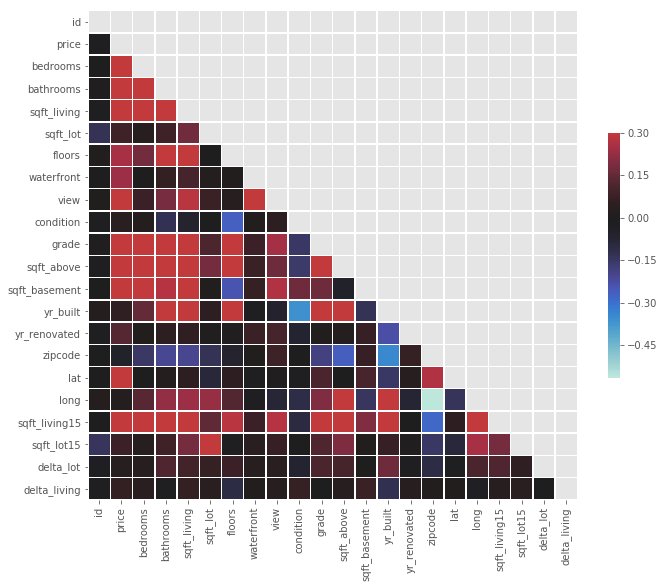

In [9]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
df_pred = df.drop(['id','price'], axis = 1)

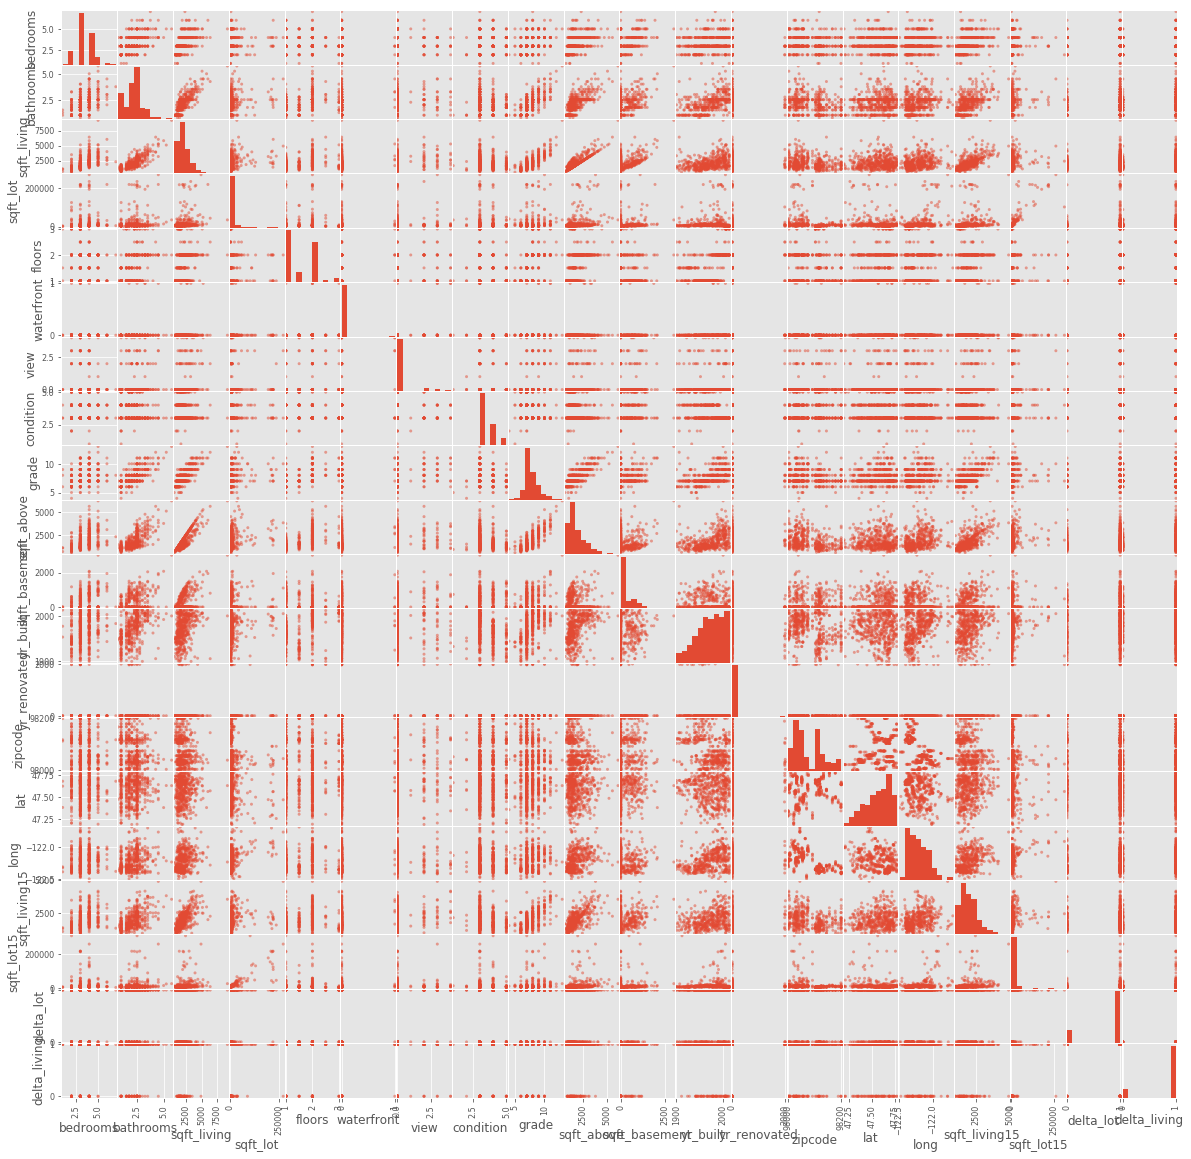

In [14]:
pd.plotting.scatter_matrix(df_pred.sample(500),figsize  = [20, 20]);

In [17]:
abs(df.corr()) > 0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,delta_lot,delta_living
id,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
